<h3 align="center">*"Everything should be made as simple as possible, but not simpler"*, Albert Einstein</h3> 


# Overfitting and Regularization

In this checkpoint, we focus on the problem of overfitting and **regularization** which is one solution to this problem. After that, we'll explore **lasso** and **ridge regression** which are two approaches to linear regression that incorporate regularization in their loss functions.

We'll cover the following concepts:

- overfitting
- underfitting
- generalization
- regularization
- ridge regression
- lasso regression
- ElasticNet regression

At the end of this checkpoint, you'll complete an assignment in which you revisit your housing prices model.




## More on overfitting

One of the main challenges in machine learning is to design models that perform well not just on a training set but also on a test set or more generally on unseen observations. More concretely, we want: 

* our models have low error rate on the training set
* the difference between the errors in the test set and in the training set to be also be low

The model's ability to achieve that second requirement is called **generalization** and the difference between the errors in the test and training sets is called the **generalization gap**. A good model should generalize well, and its generalization gap should be as small as possible.

Overfitting and underfitting are foundational concepts in machine learning and understanding them is crucial for designing good models. If the generalization gap of a model is larger than we want, we call this **overfitting**. If the training performance of a model is low, then we call this **underfitting**.

When we were discussing the goodness of fit of the linear regression models in this module, we were actually trying to come up with models that didn't underfit. However, avoiding underfitting is one part of the selection of a good model. The second part is related to prediction, and it's where the discussion of overfitting comes in.

To understand overfitting better, we'll illustrate it with an example. Below, we'll generate a quadratic relationship between two variables. Then, we'll estimate the relationship with linear regression models using a linear, a quadratic and a $10^{th}$ order polynomial of the feature seperately.

In [3]:
# These are the libraries we use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:
# X is the feature.
X = pd.DataFrame(25 - np.arange(1,51)) 

# We define Y as a quadratic function of X.
Y = X + X**2 +  pd.DataFrame(np.random.normal(0,100,50))

# This is the model with linear feature
lrm_underfit = LinearRegression().fit(X, Y)
preds_underfit = lrm_underfit.predict(X)

# This is the model with quadratic feature
X_correct = pd.concat([X, X**2], axis=1)
lrm_correct = LinearRegression().fit(X_correct, Y)
preds_correct = lrm_correct.predict(X_correct)

# This is the model with up to 10th order polynomial of the feature
X_overfit = pd.concat([X, X**2, X**3, X**4, X**5, X**6, X**7, X**8, X**9, X**10], axis=1)
lrm_overfit = LinearRegression().fit(X_overfit, Y)
preds_overfit = lrm_overfit.predict(X_overfit)

/Users/benjaminwhite/sites/Thinkful/curricula/machine-learning-regression-problems/venv/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


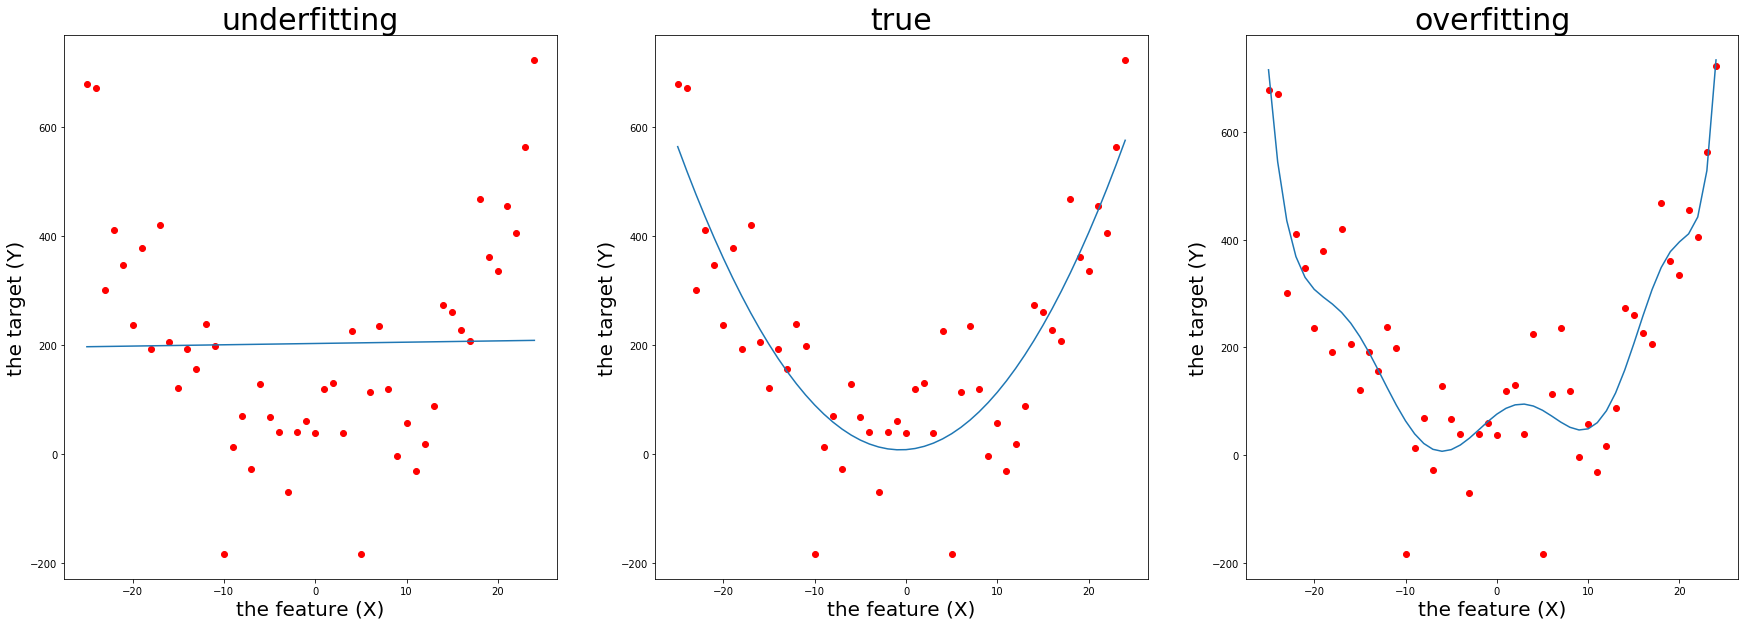

In [5]:
# We plot the predictions of the three models.
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.scatter(X, Y, color="red")
plt.plot(X, preds_underfit)
plt.title("underfitting", fontsize=30)
plt.xlabel("the feature (X)", fontsize=20)
plt.ylabel("the target (Y)", fontsize=20)

plt.subplot(1,3,2)
plt.scatter(X, Y, color="red")
plt.plot(X, preds_correct)
plt.title("true", fontsize=30)
plt.xlabel("the feature (X)", fontsize=20)
plt.ylabel("the target (Y)", fontsize=20)

plt.subplot(1,3,3)
plt.scatter(X, Y, color="red")
plt.plot(X, preds_overfit)
plt.title("overfitting", fontsize=30)
plt.xlabel("the feature (X)", fontsize=20)
plt.ylabel("the target (Y)", fontsize=20)

plt.show()

The first chart demonstrates underfitting. Since the true relationship is quadratic, by fitting a straight line, the model does a poor job explaining variation in the target.

The third chart illustrates overfitting. The $10^{th}$ order polynomial fits the noise in the data. If we look at the right most part of the fitted blue line in the third graph, we see that the line starts to turn down. However, all of the target values for large values of the feature will continue to come towards the upper-right of the graph. Hence, the model in the third chart will not correctly predict those values.

The second chart depicts the true relationship between the data. The fitted line is insensitive to noise and captures the correct relationship.

As a general rule, if our model is more complex than necessary, it will tend to overfit. Inversely, if our model is less complex than necessary, then it will underfit the training set.

Keep in mind that a model's complexity is also referred to as its**capacity**. So, if we find that our model is overfitting, we should reduce the complexity or capacity of the model. We can do this, by eliminating some unimportant variables from the model or by reducing the degree of the polynomial. In addition, there are also some general approaches to deal with overfitting. One of them is **regularization** which we'll cover in this checkpoint.

Below, we'll use the house prices dataset and create a very complex model to overfit the data. Specifically, we'll use all of the numerical features in the data and their powers up to 21.

In [6]:
import warnings
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

# Y is the target variable
Y = houseprices_df['SalePrice']

numerical_cols = [col_name for col_name in houseprices_df.dtypes[houseprices_df.dtypes.values == 'int64'].index 
                    if col_name not in ["Id", "SalePrice"] ]

X = houseprices_df[numerical_cols]

X = pd.concat([X**i for i in range(1,21)], axis=1)

# X is the feature set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

KeyError: 'SalePrice'

As we see, the R-squared of the model in the training set is 0.95 whereas it's negative in the test set. Since the difference between them is too large, our model overfits the training set. We also printed out some prediction statistics on the test set to compare with the models we'll see in the remainder of this checkpoint.

## Regularization

To make our models generalize better on the test set, we sometimes adjust our models' learning objectives or loss functions. By doing this, we actually impose our preferences over the potential solutions and force the models to choose one of our preferred solutions insofar as a nonpreferred solution doesn't perform significantly better. In general, the term **regularization** refers to the process of modifying algorithms in order to lower the generalization gap without sacrificing training performance.

When we introduced linear regression, we said that model fit is determined by minimizing the sum of the squared differences between the predicted and actual values. This is _Ordinary Least Squares_:

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2$$

It just so happens, however, that we can get more accurate *predictions* by modifying this cost function in various ways. One way to think of this is that the OLS cost function optimizes variance explained *in the training set.*  **Ridge** and **lasso regression** are two examples of modifying this cost function. They lead to models that optimize variance explained *in the test sets.*  Generally, our goal is to make a model that tells us about the world (and not just our training sample), so ridge and lasso solutions are useful.


## Ridge regression

**Ridge regression** minimizes this cost function:

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p\beta_j^2 $$

Comparing this cost function to the OLS cost function above, you can see it consists of the OLS function with a new part to the right:

$$\lambda\sum_{j=1}^p\beta_j^2 $$

This new part imposes a penalty for large coefficients.  It represents the sum of the square of all model coefficients (numbered 1 through $p$), multiplied by the regularization parameter $\lambda$.  As $\lambda$ gets larger, the penalty for coefficient size also gets larger, and the solution that minimizes the cost function will by necessity have smaller coefficient estimates.  Regularization based on the sum of the squared weights is also called "**L2 regularization**".

**A remark on naming the lambda**: If the convention is to call the regularization parameter "*lambda*" ($\lambda$), why does SKlearn call it "*alpha*"? It's because *lambda* is a reserved keyword in Python!

The core principle behind ridge regression is that, as models become increasingly complex and features correlate with one another more and more (become _multicolinear_), coefficients arrived at by OLS become increasingly large. This is a sign that the model is incorporating too much variance from the dataset – in other words, overfitting. Ridge regression is a model variance minimizer and works to keep that from happening. For a deep dive into the underlying math and origin of the term "ridge regression" see this detailed [Stack Exchange answer](http://stats.stackexchange.com/questions/151304/why-is-ridge-regression-called-ridge-why-is-it-needed-and-what-happens-when).

Now, we build a ridge regression model on the house prices data to deal with the overfitting of our previous model. We use the same features with the linear regression model above:

In [7]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.
ridgeregr = Ridge(alpha=10**37) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model in training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


NameError: name 'X_train' is not defined

The R-squared of the training set dropped from 0.95 to 0.67. Although this seems like a deterioration, if we look at the R-squared in the test set we see that it's now 0.30 which marks a significant jump from negative. Moreover, all of the performance statistics from the test set improved quite substantially. These mean that by using Ridge regression, we reduced the magnitude of the overfitting.

### Tuning ridge's regularization parameter

In the model above, we set the regularization parameter $\lambda=10^{37}$. In ridge regression, the regularization parameter $\lambda$ can take any value greater than 0. The best way to choose an optimal regularization parameter is through cross-validation, checking which parameter gives the most consistent results across training and test sets.

## Lasso regression

Ridge regression shrinks parameter estimates, but the estimates never reach exactly 0.  **LASSO** (Least Absolute Shrinkage and Selection Operator), on the other hand, is a model optimization mechanic that works by trying to force small parameter estimates to be equal to zero, effectively dropping them from the model.  This can prevent overfitting, and also works as an **embedded feature selection method**.  Lasso is extremely handy when you are dealing with thousands or hundreds of thousands of predictors and need to optimize processor time, or when you want to arrive at a simpler solution that is easier to interpret.

The cost function to minimize for lasso is _very similar_ to the cost function minimized for ridge:

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p|\beta_j| $$

The difference is that rather than penalizing by the sum of *squared* coefficients as ridge does, lasso penalizes by the sum of the *absolute values* of the coefficients.  This means the penalty doesn't increase as swiftly with coefficient size.  Regularization based on the sum of the absolute weights is also called "**L1 regularization**".

Why would penalizing with the sum of the absolute values of coefficients lead to a solution with zero estimates for some parameters, while penalizing with the sum of the squares of coefficients does not?  It all comes down to derivatives. A partial derivative represents the sensitivity of one quantity to changes in another quantity.  In the case of both ordinary least squares regression and ridge regression, the derivative used to find the optimal solution is the partial derivative of the cost function relative to the coefficients in $\beta$:

$$\frac{\partial}{\partial\beta}$$

Unfortunately, that won't work for lasso. While we can calculate a derivative for most of the values of $x$ in lasso, there is no derivative where $x=0$.  You can imagine this as our multi-dimensional surface made up of gradients having a big hole in it (the technical term for the hole is a "*discontinuity*"). If the gradient descent algorithm calculates a value that falls in the "hole", it has no idea where to go next.  The model "fails to converge". In other words, it fails to arrive at an optimal solution.

Now, let's fit a Lasso regression model on the house prices data we're using in this checkpoint. As usual, we use the same features that we used in the previous models.

In [178]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**20) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model in training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model in training set is: 0.7911868553732757
-----Test set statistics-----
R-squared of the model in test set is: 0.5829006527639291
Mean absolute error of the prediction is: 36381.658980543725
Mean squared error of the prediction is: 3022037761.12746
Root mean squared error of the prediction is: 54973.06395979271
Mean absolute percentage error of the prediction is: 21.183020343286596


The R-squared is 0.79 in the train set and 0.58 in the test set. The R-squared value in the test set is the highest among the models we covered in this checkpoint. Also, the difference between the R-squareds of the train and test set is also the lowest. All of the performance statistics on the test set are also the lowest which means that this Lasso model performs better than both the Ridge regression and the linear regression models we built previously.

### Tuning the regularization parameter

The $\lambda$ for lasso can vary between 0 (no penalty, acts like OLS) and infinity.  If $\lambda$ is too large, all parameters will be set to zero. 

## ElasticNet regression

As we emphasized in our previous discussions in this checkpoint, both Lasso and Ridge regressions has its own merits and drawbacks. One popular method that combines both Lasso's L1 regularization and Ridge's L2 regularization is called **ElasticNet regression**. The loss function of elasticnet regression is: 

$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda_1\sum_{j=1}^p|\beta_j| +\lambda_2\sum_{j=1}^p\beta_j^2$$

Notice that wheb $\lambda_1$ is equal to zero, this loss function turns into the loss function of Ridge regression and when $\lambda_2$ is equal to zero it becomes the loss function of Lasso regression. Hence both Lasso and Ridge regressions are a special case of elasticnet regression.

In [192]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**21, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model in training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model in training set is: 0.6875287519193916
-----Test set statistics-----
R-squared of the model in test set is: 0.41453606533067333
Mean absolute error of the prediction is: 42843.88808104702
Mean squared error of the prediction is: 4241900952.5507026
Root mean squared error of the prediction is: 65129.877572053694
Mean absolute percentage error of the prediction is: 23.41793772774104


## Assignment

In this assignment, you'll work with the house prices data. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Reimplement your model from the previous checkpoint.
* Try Lasso, Ridge and ElasticNet regressions using the same model specification. This time, you need to do k-fold cross-validation to choose the best hyperparameter values for your models. Which model is the best? Why?